# Proyecto Estructura y Bases de Datos

*   Antonia Morales
*   Ángel Paisano
*   Martín Raffo
*   Esteban Sánchez





# Introducción

El presente proyecto consiste en un análisis comparativo de dos data release (DR2 y DR3) de la misión Gaia a través de herramientas propias de la ciencia de datos. Los datasets son cargados a Python utilizando la API Astroquery y procesados con ADQL (Astronomical Data Query Language, lenguaje idéntico a SQL pero con funciones integradas para trabajar datos astronómicos). Luego, con ellos, se pobla una base de datos SQL a la cual se le hacen consultas, para después elaborar gráficos que contribuyen a la interpretación de los resultados obtenidos.

Gaia es un telescopio espacial lanzado el año 2013 por la ESA (European Space Agency) cuyo propósito es construir el catálogo más grande y más completo posible del espacio. A la fecha, esta sonda ha logrado reunir datos de más de mil millones de objetos astronómicos de diversa índole como estrellas, planetas, quásares y más.

Para el proyecto es conveniente trabajar con SQL debido a la naturaleza de los datos: éstos son homogéneos, fácilmente organizables en tablas de tipo relacional y no variables en el tiempo. Cabe destacar que, si bien TaQL también es utilizado para bases de datos relacionales, tampoco es una elección adecuada en este contexto, puesto que su enfoque es trabajar información proveniente de observaciones en radio, mientras que los datos de Gaia se encuentran en la banda del óptico.


# Gaia

In [1]:
#Instalando astroquery
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 48.2 MB/s eta 0:00:00


In [2]:
#Se importan librerías
from astroquery.gaia import Gaia
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Se cargan las tablas
tables = Gaia.load_tables(only_names=True)

INFO:astroquery:Retrieving tables...


INFO: Retrieving tables... [astroquery.utils.tap.core]


INFO:astroquery:Parsing tables...
INFO:astroquery:Done.


INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [4]:
#Imprimir nombres de tablas
for table in tables:
    print(table.name)

external.apassdr9
external.catwise2020
external.gaiadr2_astrophysical_parameters
external.gaiadr2_geometric_distance
external.gaiaedr3_distance
external.gaiaedr3_gcns_main_1
external.gaiaedr3_gcns_rejected_1
external.gaiaedr3_spurious
external.gaia_eso_survey
external.galex_ais
external.lamost_dr9_lrs
external.lamost_dr9_mrs
external.ravedr5_com
external.ravedr5_dr5
external.ravedr5_gra
external.ravedr5_on
external.ravedr6
external.sdssdr13_photoprimary
external.skymapperdr1_master
external.skymapperdr2_master
external.tmass_xsc
external.xgboost_table1
external.xgboost_table2
gaiadr1.aux_qso_icrf2_match
gaiadr1.ext_phot_zero_point
gaiadr1.allwise_best_neighbour
gaiadr1.allwise_neighbourhood
gaiadr1.gsc23_best_neighbour
gaiadr1.gsc23_neighbourhood
gaiadr1.ppmxl_best_neighbour
gaiadr1.ppmxl_neighbourhood
gaiadr1.sdss_dr9_best_neighbour
gaiadr1.sdss_dr9_neighbourhood
gaiadr1.tmass_best_neighbour
gaiadr1.tmass_neighbourhood
gaiadr1.ucac4_best_neighbour
gaiadr1.ucac4_neighbourhood
gaiadr1.u

## ADQL
La muestra de la gran nube de magallanes (siglas en inglés: LMC) se obtiene usando una selección con un radio de 20° con $α,δ$ (81.28°,-67.78°). El trabajo se enfocará en esta región del cielo para procesar datos de la galaxia anteriormente mencionada, estudiando las posiciones en el cielo de las fuentes astronómicas (sources), sus movimientos propios, y las magnitudes en distintos filtros. Este paso está basado en el artículo científico de Luri et al (2021) que se dedica a seleccionar datos de Gaia EDR3 en la región de la LMC.

Después de hacer las consultas pertinentes en Gaia DR2 y DR3 para obtener los datos de las fuentes en las Nubes de Magallanes, se guardan los resultados en tablas de Astropy.

In [5]:
# Consulta a Gaia y conversión
job0 = Gaia.launch_job_async("""SELECT TOP 100000 source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag,
                      phot_rp_mean_mag FROM gaiadr2.gaia_source
                      WHERE DISTANCE(POINT(81.28, -69.78), POINT(ra, dec)) < 20
                      AND gaiadr2.gaia_source.parallax IS NOT NULL""")
tabla_gaiadr2 = job0.get_results()  # Resultado en formato Table de Astropy

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
tabla_gaiadr2

SOURCE_ID,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag
int64,float64,float64,float64,float64,float64,float32,float32,float32
4658244220002588544,78.72686168615897,-69.17099189770968,-575.5025136625242,-23.552455433071792,88.49457165348872,20.645891,--,--
4658166296309500928,79.97366861131795,-69.67770711879938,-377.2946158419197,31.802266832043692,322.6482994179345,20.287218,--,--
4657890456331142144,82.82136548519769,-70.26717187975918,-162.37362153662139,-62.333188547633355,-76.1982624898421,20.198992,--,--
4658176157502513920,80.31125378631981,-69.44566527653164,-141.46738198239416,1661.1624724600404,1340.778998980298,19.488197,--,--
4657255591411648640,84.30446235759861,-69.97628405710026,-103.35695045280868,-35.057101266343324,60.29657042662194,20.313425,--,--
4657985014366176384,80.58360995717557,-69.59842619127859,-102.87942444416687,-707.6690203604887,-76.73729265515409,19.78807,--,--
4658138666804691200,79.94753664308574,-69.90701912843755,-85.94015767662628,-190.30343480981824,217.3217344640828,20.392328,--,--
5265007551257877632,90.26266341491082,-74.32741784151612,-78.92453974063712,-117.01825608161492,68.2943550499956,19.345762,18.947803,17.659748


La siguiente consulta a Gaia DR2 tiene el objetivo de conseguir el RUWE (Renormalised Unit Weight Error) para el dataset en cuestión. Este parámetro es una normalización de la función chi cuadrado que funciona como una medida del error de los datos y será útil para hacer un filtro de los mismos, logrando resultados más precisos.

In [7]:
#Obtención de RUWE para Gaia DR2
job1 = Gaia.launch_job_async("""SELECT TOP 100000 gaiadr2.gaia_source.source_id, gaiadr2.ruwe.ruwe
                            FROM gaiadr2.ruwe JOIN gaiadr2.gaia_source
                            ON gaiadr2.ruwe.source_id = gaiadr2.gaia_source.source_id
                            WHERE DISTANCE(POINT(81.28, -69.78),POINT(ra, dec)) < 20
                            AND gaiadr2.gaia_source.parallax IS NOT NULL""")

tabla_ruwe_dr2 = job1.get_results()

tabla_ruwe_dr2

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


SOURCE_ID,ruwe
int64,float32
4658244220002588544,1.2430887
4658166296309500928,1.2341515
4657890456331142144,0.9704376
4658176157502513920,1.1267815
4657255591411648640,2.397002
4657985014366176384,1.6086564
4658138666804691200,1.1972814
5265007551257877632,1.184043
4658487422372518784,1.6824956


In [8]:
# Consulta a Gaia y conversión DR3
job2 = Gaia.launch_job_async("""SELECT TOP 100000 source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag,
                      phot_rp_mean_mag, ruwe FROM gaiadr3.gaia_source
                      WHERE DISTANCE(POINT(81.28, -69.78),POINT(ra, dec)) < 20
                      AND gaiadr3.gaia_source.parallax IS NOT NULL""")
tabla_gaiadr3 = job2.get_results()  # Resultado en formato Table de Astropy

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
tabla_gaiadr3

SOURCE_ID,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32
4658236080911512448,78.5514024561908,-69.34938949564625,-54.47427884418308,6.099950647710691,-4.440973490152747,19.420551,--,--,1.5995979
4755896455997449856,87.60944531792067,-65.6193910014861,-29.754228397711486,1.1055655417649002,-1.9784777622983987,20.627981,20.731478,19.906069,1.1859884
4658827034041674496,78.98865728993457,-67.41405756228902,-28.516841793456223,2.150618458910637,-0.271032618672317,20.684961,20.493795,19.83451,1.6031476
4650933945016145280,83.70880588880668,-71.88025885990012,-26.940253549851757,-0.9666089941522282,15.613932418458852,20.776564,20.860954,19.187275,1.3682157
4661376286081623808,77.51696655431459,-68.43031122888497,-23.734879450271023,-10.440825907151893,-31.305632330644006,20.757942,20.521837,19.563786,1.4107646
4654953725148442624,71.86570595395773,-70.03897514497481,-22.57804325477345,-7.886638495915903,2.8751139249303614,20.792788,20.77215,19.996368,1.30683
4661546263710670080,74.69473137406783,-68.08659493221936,-22.476060762262307,1.927663826710482,5.956942478515257,20.8444,20.039173,19.522255,0.93420297
4656976689153527168,87.61868786729396,-70.59082891065862,-22.37769046222033,-15.559220846507932,-1.9941102353106592,20.60069,19.848104,19.620773,1.3410082


## Pandas

Ya teniendo las tablas de Astropy, se transforman a Dataframes de Pandas para eventualmente poblar con éstas una base de datos SQL y construir tablas de tipo relacional.


In [10]:
df_gaiadr2 = tabla_gaiadr2.to_pandas()
df_gaiadr2 = df_gaiadr2.rename(columns={"SOURCE_ID": "source_id"})
df_gaiadr2["ruwe"] = tabla_ruwe_dr2["ruwe"]

In [11]:
df_gaiadr2

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
0,4658244220002588544,78.726862,-69.170992,-575.502514,-23.552455,88.494572,20.645891,NaN,NaN,1.243089
1,4658166296309500928,79.973669,-69.677707,-377.294616,31.802267,322.648299,20.287218,NaN,NaN,1.234151
2,4657890456331142144,82.821365,-70.267172,-162.373622,-62.333189,-76.198262,20.198992,NaN,NaN,0.970438
3,4658176157502513920,80.311254,-69.445665,-141.467382,1661.162472,1340.778999,19.488197,NaN,NaN,1.126781
4,4657255591411648640,84.304462,-69.976284,-103.356950,-35.057101,60.296570,20.313425,NaN,NaN,2.397002
...,...,...,...,...,...,...,...,...,...,...
99995,4661280383839905792,76.403518,-68.727793,-3.289102,-3.157519,6.036777,20.498653,19.284431,18.990639,1.075176
99996,4658138563722903296,79.959983,-69.927512,-3.289075,6.244045,8.946144,20.292023,19.497135,18.772638,1.878865
99997,4658702269573365888,80.601822,-68.429397,-3.289073,3.362459,5.781591,20.788260,19.573959,19.173664,1.024510
99998,4657779371237696384,85.056173,-68.903607,-3.289058,11.848572,4.153749,20.176580,19.105860,18.310368,1.225565


In [12]:
df_gaiadr3 = tabla_gaiadr3.to_pandas()
df_gaiadr3 = df_gaiadr3.rename(columns={"SOURCE_ID": "source_id"})

In [13]:
df_gaiadr3

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
0,4658236080911512448,78.551402,-69.349389,-54.474279,6.099951,-4.440973,19.420551,NaN,NaN,1.599598
1,4755896455997449856,87.609445,-65.619391,-29.754228,1.105566,-1.978478,20.627981,20.731478,19.906069,1.185988
2,4658827034041674496,78.988657,-67.414058,-28.516842,2.150618,-0.271033,20.684961,20.493795,19.834511,1.603148
3,4650933945016145280,83.708806,-71.880259,-26.940254,-0.966609,15.613932,20.776564,20.860954,19.187275,1.368216
4,4661376286081623808,77.516967,-68.430311,-23.734879,-10.440826,-31.305632,20.757942,20.521837,19.563786,1.410765
...,...,...,...,...,...,...,...,...,...,...
99995,4657893617471218304,83.034525,-70.236550,-3.116889,-2.801122,-4.480014,19.274088,18.855247,18.417500,2.090748
99996,5279734680582437504,92.380731,-69.215653,-3.116888,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-3.116873,-0.150200,-1.605936,20.791613,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,-3.116865,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


# SQL

Acto seguido, se define una función que permitirá la elaboración de tablas tipo SQL a partir de los Dataframes resultantes del paso anterior. Dicha función es ejecutada para DR2 y DR3, a fin de poder realizar consultas y gráficos.

In [14]:
# Función para crear las tablas de gaia
def crear_tabla(tabla, nombre_tabla, db_name):
  """
  Esta función construye...

  """
  db = sqlite3.connect(db_name)
  cur = db.cursor()

  ############################

  cur.execute(f"""
        CREATE TABLE {nombre_tabla} (
            source_id INTEGER PRIMARY KEY AUTOINCREMENT,
            ra REAL,
            dec REAL,
            parallax REAL,
            pmra REAL,
            pmdec REAL,
            phot_g_mean_mag REAL,
            phot_bp_mean_mag REAL,
            phot_rp_mean_mag REAL,
            ruwe REAL
        );
    """)

  ####################################################
  for i, row in tabla.iterrows():
        cur.execute(f"""
            INSERT OR IGNORE INTO {nombre_tabla} (source_id, ra, dec, parallax, pmra, pmdec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, ruwe)
            VALUES (?, ?, ?, ?, ?, ?, ?, ? ,?, ?);
        """, (row['source_id'], row['ra'], row['dec'], row['parallax'], row['pmra'], row['pmdec'], row['phot_g_mean_mag'], row['phot_bp_mean_mag'], row['phot_rp_mean_mag'], row['ruwe']))

  db.commit()

  # Verificación:
  res = cur.execute(f"PRAGMA table_info({nombre_tabla})")
  if res.fetchall() != []:
    print("Tabla creada correctamente")
    print(res.fetchall())
  else:
    print("Error al crear la tabla")

  db.close()

In [15]:
#Creación de tablas con la función

crear_tabla(df_gaiadr2, 'gaiadr2', 'gaiadr2.db')

Tabla creada correctamente
[]


In [16]:
crear_tabla(df_gaiadr3, 'gaiadr3', 'gaiadr3.db')

Tabla creada correctamente
[]


# Querys SQL

Una vez ya se han creado las tablas de SQL, éstas pueden ser trabajadas en Python con un cursor de sqlite3. De este modo, se realizan diversas consultas

In [17]:
db = sqlite3.connect('gaiadr2.db')
cur = db.cursor()
cur.execute("ATTACH DATABASE 'gaiadr3.db' AS gaiadr3;")

In [18]:
res = cur.execute(f"""PRAGMA table_info(gaiadr2)""")
res.fetchall()

[(0, 'source_id', 'INTEGER', 0, None, 1),
 (1, 'ra', 'REAL', 0, None, 0),
 (2, 'dec', 'REAL', 0, None, 0),
 (3, 'parallax', 'REAL', 0, None, 0),
 (4, 'pmra', 'REAL', 0, None, 0),
 (5, 'pmdec', 'REAL', 0, None, 0),
 (6, 'phot_g_mean_mag', 'REAL', 0, None, 0),
 (7, 'phot_bp_mean_mag', 'REAL', 0, None, 0),
 (8, 'phot_rp_mean_mag', 'REAL', 0, None, 0),
 (9, 'ruwe', 'REAL', 0, None, 0)]

In [19]:
query0 = cur.execute(f"""SELECT COUNT(*) FROM gaiadr2""")
query0.fetchall()

[(99852,)]

In [20]:
query1 = cur.execute(f"""SELECT COUNT(*) FROM
                      (SELECT gaiadr2.source_id AS source_id_gaiadr2,
                      gaiadr3.source_id AS source_id_gaiadr3 FROM gaiadr2
                      JOIN gaiadr3 ON gaiadr2.source_id=gaiadr3.source_id)""")
query1.fetchall()

[(17318,)]

In [21]:
query2 = cur.execute(f"""SELECT ROW_NUMBER() OVER(ORDER BY gaiadr2.source_id) AS row_number,
                          gaiadr2.source_id AS source_id_gaiadr2,
                          gaiadr3.source_id AS source_id_gaiadr3
                        FROM gaiadr2
                        JOIN gaiadr3
                        ON gaiadr2.source_id = gaiadr3.source_id;""")

rows = query2.fetchall()
for row in rows:
    print(f"Numero de Columna: {row[0]}, GAIADR2 Source ID: {row[1]}, GAIADR3 Source ID: {row[2]}")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Numero de Columna: 12319, GAIADR2 Source ID: 4661338520596084736, GAIADR3 Source ID: 4661338520596084736
Numero de Columna: 12320, GAIADR2 Source ID: 4661338657894548480, GAIADR3 Source ID: 4661338657894548480
Numero de Columna: 12321, GAIADR2 Source ID: 4661338868380075008, GAIADR3 Source ID: 4661338868380075008
Numero de Columna: 12322, GAIADR2 Source ID: 4661339108898899968, GAIADR3 Source ID: 4661339108898899968
Numero de Columna: 12323, GAIADR2 Source ID: 4661339173430269952, GAIADR3 Source ID: 4661339173430269952
Numero de Columna: 12324, GAIADR2 Source ID: 4661339693013671936, GAIADR3 Source ID: 4661339693013671936
Numero de Columna: 12325, GAIADR2 Source ID: 4661340135405388800, GAIADR3 Source ID: 4661340135405388800
Numero de Columna: 12326, GAIADR2 Source ID: 4661340174052482048, GAIADR3 Source ID: 4661340174052482048
Numero de Columna: 12327, GAIADR2 Source ID: 4661340242771548160, GAIADR3 Source ID: 46613402

In [22]:
query3 = cur.execute("""SELECT COUNT(*) AS n FROM (SELECT gaiadr2.source_id, gaiadr2.phot_rp_mean_mag FROM gaiadr2
                        JOIN gaiadr3 ON gaiadr2.source_id = gaiadr3.source_id
                        WHERE gaiadr2.phot_rp_mean_mag < 20)""")
query3.fetchall()

[(11175,)]

In [23]:
query4 = cur.execute("""CREATE TABLE dr2_filtro AS SELECT * FROM gaiadr2 WHERE gaiadr2.ruwe < 1.4 ORDER BY ruwe DESC""")
query4.fetchall()

[]

# Gráficos

In [24]:
plt.style.use('dark_background')

In [25]:
#Variables (DR2)
ra_dr2 = df_gaiadr2['ra']
dec_dr2 = df_gaiadr2['dec']
pmra_dr2 = df_gaiadr2['pmra']
pmdec_dr2 = df_gaiadr2['pmdec']
mag_bp_dr2 = df_gaiadr2['phot_bp_mean_mag']
mag_rp_dr2 = df_gaiadr2['phot_rp_mean_mag']
mag_g_dr2 = df_gaiadr2['phot_g_mean_mag']
ruwe_dr2 = df_gaiadr2['ruwe']

In [39]:
#Variables (DR3)
ra_dr3 = df_gaiadr3['ra']
dec_dr3 = df_gaiadr3['dec']
pmra_dr3 = df_gaiadr3['pmra']
pmdec_dr3 = df_gaiadr3['pmdec']
mag_bp_dr3 = df_gaiadr3['phot_bp_mean_mag']
mag_rp_dr3 = df_gaiadr3['phot_rp_mean_mag']
mag_g_dr3 = df_gaiadr3['phot_g_mean_mag']
ruwe_dr3 = df_gaiadr3['ruwe']

In [27]:
df_filtro_dr2 = pd.read_sql_query("SELECT * FROM dr2_filtro", db)
df_filtro_dr2

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
0,4655439434453728256,71.546131,-69.133007,-3.375677,-9.416842,0.893864,20.644880,20.234013,19.884539,1.399971
1,4658251817728041984,78.252521,-68.953823,-5.473766,0.510560,7.355826,20.158316,NaN,NaN,1.399954
2,4650998438206648320,86.223475,-71.671421,-3.928748,-1.486508,1.931329,19.683619,19.501051,19.353479,1.399940
3,4652109292891295744,78.497192,-70.357433,-3.712214,3.270125,3.043588,20.419359,NaN,NaN,1.399929
4,4658334826558458880,79.821047,-68.482944,-9.609162,-18.860264,7.364115,20.857990,NaN,NaN,1.399924
...,...,...,...,...,...,...,...,...,...,...
65085,4654725370344893440,74.504770,-70.699317,-3.441722,-4.541816,2.449190,20.988951,21.146971,20.495489,0.658257
65086,4657396736936100864,87.715381,-69.930478,-3.753096,3.369218,3.166788,20.856905,20.485407,20.094849,0.654563
65087,4663630869045860352,79.052244,-65.299576,-5.540746,6.814468,-1.328949,20.818068,20.543922,20.486216,0.646915
65088,4659587410743501824,89.568198,-67.161503,-3.699289,2.118885,4.010352,20.852633,20.607983,19.467335,0.637519


In [28]:
#Variables filtradas por RUWE (DR2)

ra_dr2_filtro = df_filtro_dr2['ra']
dec_dr2_filtro = df_filtro_dr2['dec']
pmra_dr2_filtro = df_filtro_dr2['pmra']
pmdec_dr2_filtro = df_filtro_dr2['pmdec']
mag_g_dr2_filtro = df_filtro_dr2['phot_g_mean_mag']
mag_bp_dr2_filtro = df_filtro_dr2['phot_bp_mean_mag']
mag_rp_dr2_filtro = df_filtro_dr2['phot_rp_mean_mag']

In [37]:
filtro_ruwe_dr3 = df_gaiadr3['ruwe'] < 1.4
filtro_ruwe_dr3 = df_gaiadr3[filtro_ruwe_dr3]
filtro_ruwe_dr3

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe
1,4755896455997449856,87.609445,-65.619391,-29.754228,1.105566,-1.978478,20.627981,20.731478,19.906069,1.185988
3,4650933945016145280,83.708806,-71.880259,-26.940254,-0.966609,15.613932,20.776564,20.860954,19.187275,1.368216
5,4654953725148442624,71.865706,-70.038975,-22.578043,-7.886638,2.875114,20.792788,20.772150,19.996368,1.306830
6,4661546263710670080,74.694731,-68.086595,-22.476061,1.927664,5.956942,20.844400,20.039173,19.522255,0.934203
7,4656976689153527168,87.618688,-70.590829,-22.377690,-15.559221,-1.994110,20.600691,19.848104,19.620773,1.341008
...,...,...,...,...,...,...,...,...,...,...
99994,4657764214357813632,85.796404,-68.613786,-3.116910,0.703448,4.371127,20.782845,21.045977,20.445887,0.949053
99996,5279734680582437504,92.380731,-69.215653,-3.116888,2.599397,-1.402853,20.684196,21.083527,20.404102,1.172152
99997,4660786982217476352,82.333518,-65.437197,-3.116873,-0.150200,-1.605936,20.791613,20.636160,20.368301,1.181278
99998,4650831625970626560,85.141312,-72.745979,-3.116865,6.976692,-1.859763,20.744085,20.699068,20.161112,1.093063


In [43]:
#Variables filtradas por RUWE (DR3)

ra_dr3_filtro = filtro_ruwe_dr3['ra']
dec_dr3_filtro = filtro_ruwe_dr3['dec']
pmra_dr3_filtro = filtro_ruwe_dr3['pmra']
pmdec_dr3_filtro = filtro_ruwe_dr3['pmdec']
mag_g_dr3_filtro = filtro_ruwe_dr3['phot_g_mean_mag']
mag_bp_dr3_filtro = filtro_ruwe_dr3['phot_bp_mean_mag']
mag_rp_dr3_filtro = filtro_ruwe_dr3['phot_rp_mean_mag']

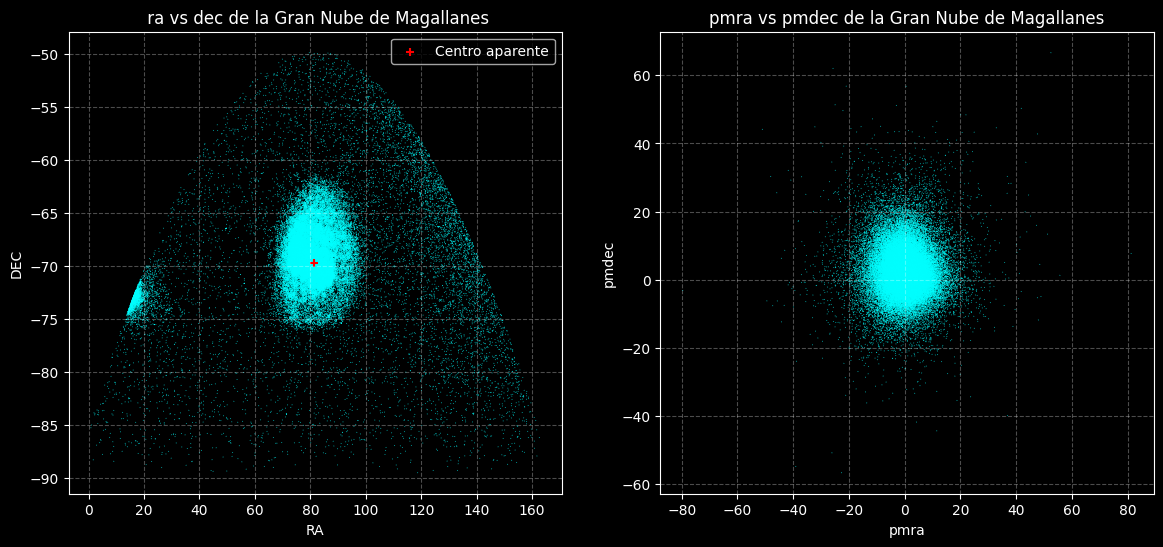

In [31]:
# Datos Sin filtrar para DR3
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

ax1.scatter(ra_dr3, dec_dr3, c='cyan', marker='*',s=1, edgecolors= "none") #c=brillo, cmap='plasma',s=(1/brillo)*40)
ax1.scatter(81.28, -69.78, marker="+", facecolor="red",label='Centro aparente', s=40)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title(" ra vs dec de la Gran Nube de Magallanes")
ax1.grid(ls='--', alpha=0.3)
ax1.legend()

ax2= fig.add_subplot(122)

ax2.scatter(pmra_dr3, pmdec_dr3, c='cyan', marker='*',s=1, edgecolors= "none") #c=brillo, cmap='plasma',s=(1/brillo)*40)
ax2.set_xlabel("pmra")
ax2.set_ylabel("pmdec")
ax2.set_title("pmra vs pmdec de la Gran Nube de Magallanes")
ax2.grid(ls='--', alpha=0.3)
plt.show()

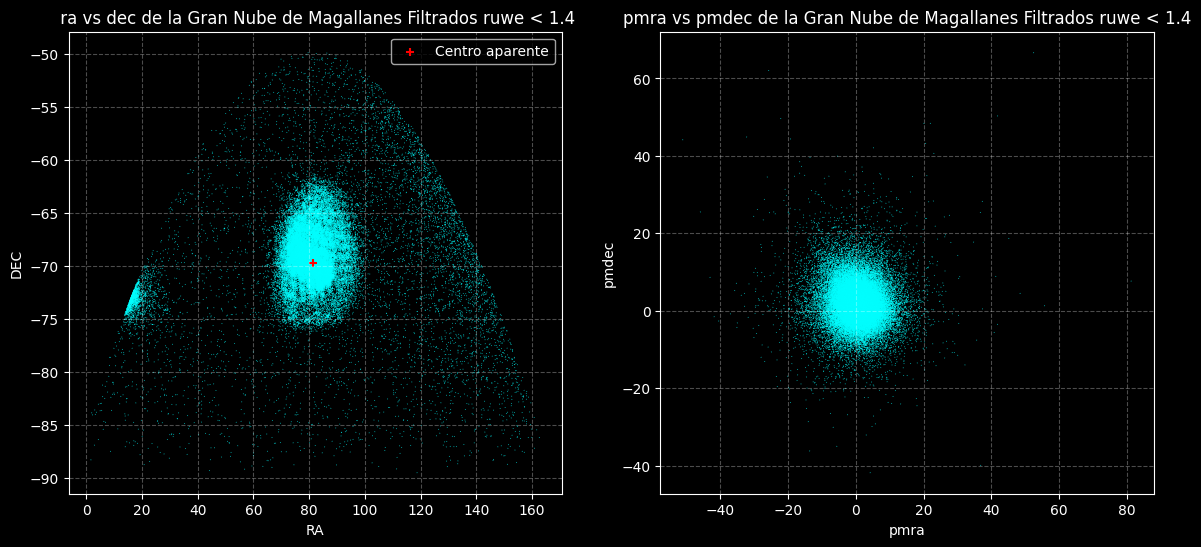

In [36]:
# Datos filtrados por RUWE para Dr3
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

ax1.scatter(ra_dr3_filtro, dec_dr3_filtro, c='cyan', marker='*',s=1, edgecolors= "none") #c=brillo, cmap='plasma',s=(1/brillo)*40)
ax1.scatter(81.28, -69.78, marker="+", facecolor="red",label='Centro aparente', s=40)
ax1.set_xlabel("RA")
ax1.set_ylabel("DEC")
ax1.set_title(" ra vs dec de la Gran Nube de Magallanes Filtrados ruwe < 1.4")
ax1.grid(ls='--', alpha=0.3)
ax1.legend()

ax2= fig.add_subplot(122)

ax2.scatter(pmra_dr3_filtro, pmdec_dr3_filtro, c='cyan', marker='*',s=1, edgecolors= "none") #c=brillo, cmap='plasma',s=(1/brillo)*40)
ax2.set_xlabel("pmra")
ax2.set_ylabel("pmdec")
ax2.set_title("pmra vs pmdec de la Gran Nube de Magallanes Filtrados ruwe < 1.4")
ax2.grid(ls='--', alpha=0.3)
plt.show()

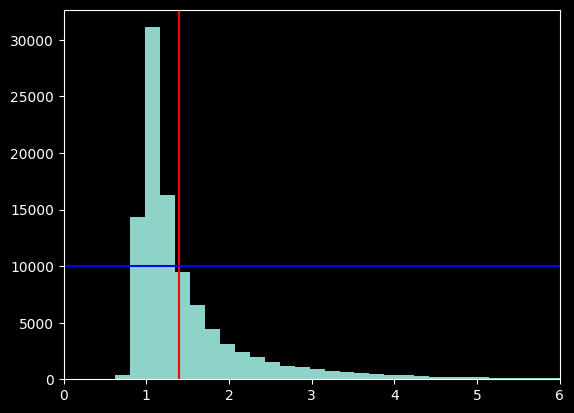

In [33]:
#Histograma de RUWE (DR2)
plt.hist(ruwe_dr2, bins = 500)
plt.axvline(1.4, color = 'red')
plt.axhline(10000, color = 'blue')
plt.xlim(0,6)
plt.show()

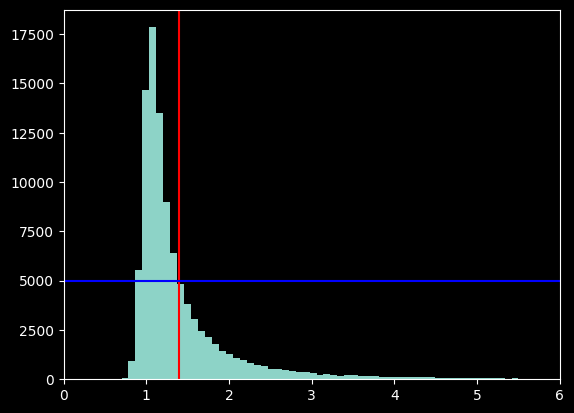

In [40]:
#Histograma de RUWE (DR3)
plt.hist(ruwe_dr3, bins = 500)
plt.axvline(1.4, color = 'red')
plt.axhline(5000, color = 'blue')
plt.xlim(0,6)
plt.show()

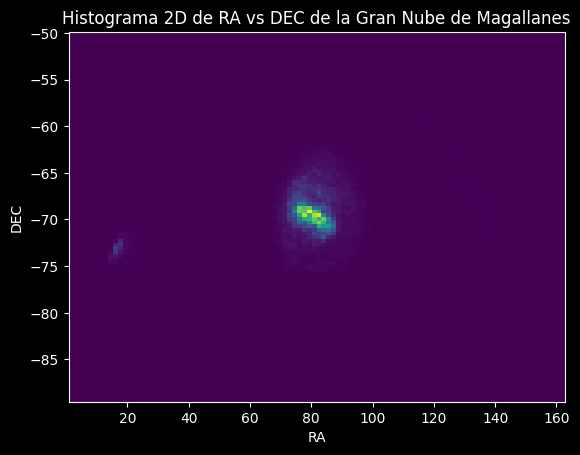

In [41]:
#Histograma 2D

plt.hist2d(ra_dr3, dec_dr3, bins = 100)
plt.title("Histograma 2D de RA vs DEC de la Gran Nube de Magallanes")
plt.xlabel("RA")
plt.ylabel("DEC")
plt.show()

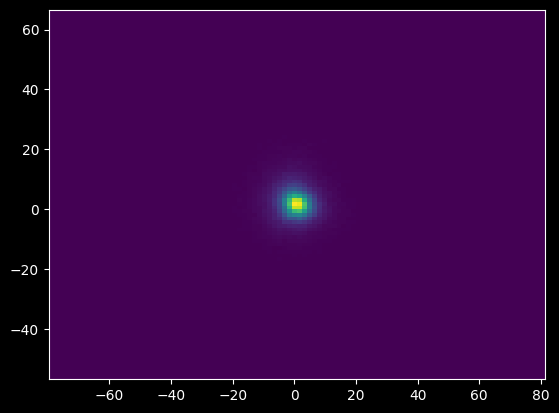

In [42]:
#Histograma 2D (movimientos propios)

plt.hist2d(pmra_dr3, pmdec_dr3, bins = 100)
plt.show()

## Diagrama color magnitud test
BP-RP vs G

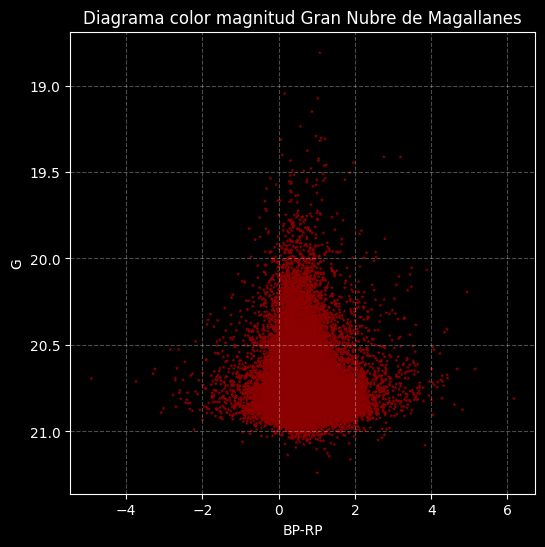

In [44]:
#añadir errorbars y colorbars

fig = plt.figure(1,figsize=(6,6))
ax1= fig.add_subplot(111)
ax1.scatter(mag_bp_dr3_filtro - mag_rp_dr3_filtro, mag_g_dr3_filtro,c='darkred',marker='*',s=10, edgecolors= "none") #c=brillo, cmap='plasma',s=(1/brillo)*40)
#ax1.scatter((mag_bp-mag_rp)[i], mag_g[i],marker="*",edgecolor="none", facecolor="red",s=10)
ax1.set_xlabel("BP-RP")
ax1.set_ylabel("G")
ax1.set_title("Diagrama color magnitud Gran Nubre de Magallanes")
ax1.grid(ls='--', alpha=0.3)
#plt.ylim(16,21.5)
plt.gca().invert_yaxis()

plt.show()

# Conclusión

paremos el webeo